# Traveling salesman problem 

## Code

### Utils

In [2]:
import time
import numpy as np
import random

np.random.seed(2137)
random.seed(2137)

class TSPUtils:

    @staticmethod
    def get_random_rates(n):
        result = np.random.randint(1, 100, size=(n,n))
        result = np.tril(result) + np.tril(result, -1).T
        np.fill_diagonal(result,0)
        return result.tolist()

    @staticmethod
    def parse_timedelta(timedelta):
        if timedelta < 1e3:
            return f"{timedelta} ns"
        elif timedelta < 1e9:
            return f"{timedelta/10e6} ms"
        elif timedelta < 60 * 1e9:
            return f"{timedelta / 1e9} s"
        elif timedelta < 60 * 60 * 1e9:
            return f"{timedelta / (60 * 1e9)} m"
        elif timedelta < 24 * 60 * 60 * 1e9:
            return f"{timedelta / (60 * 60 * 1e9)} hr"
        elif timedelta < 360 * 24 * 60 * 60 * 1e9:
            return f"{timedelta / (24 * 60 * 60 * 1e9)} days"
        else:
            return f"{timedelta / (360 * 24 * 60 * 60 * 1e9)} years"

    @staticmethod
    def estimate_run_time_as_number(n, estimated_operation_time_ns = 1.74797e3):
        return math.factorial(n) * estimated_operation_time_ns
    
    @staticmethod
    def estimate_run_time(n, estimated_operation_time_ns = 1.74797e3):
        return TSPUtils.parse_timedelta(TSPUtils.estimate_run_time_as_number(n, estimated_operation_time_ns=estimated_operation_time_ns))
    

### Abstract solver

In [3]:
from abc import ABC, abstractmethod
from functools import reduce
from operator import add

class TSPSolver(ABC):

  def __init__(self, rates, labels=None):
    self.rates = rates
    self.labels = labels
    self.nodes = [i for i in range(len(rates))]

  @abstractmethod
  def solve(self):
    pass
  
  def solve_and_measure_time(self):
    start_time = time.time_ns()
    result = self.solve()
    elapsed_time = time.time_ns() - start_time
    return *result, elapsed_time

  def solve_and_report(self):
    result = self.solve_and_measure_time()
    labels = '-' if not self.labels else f" {'->'.join([self.labels[i] for i in result[0]])}"
    print(f"{self.name} :: {len(self.nodes)} :: {result[0]} :: {labels} :: {result[1]} :: {TSPUtils.parse_timedelta(result[2])}")
      
  @staticmethod
  def print_report_header():
    print("Algorithm :: number of nodes :: best path indexes :: ?best path labels? :: price :: calculation time")
    print("-------------------------------------------------------------------------------------------------------")
      
  def calculate_path_price(self, path):
    return reduce(add, [self.rates[path[i]][path[i+1]] for i in range(len(path)-1)]) \
            + self.rates[path[len(path)-1]][path[0]]

### Naive (brute-force) solver

In [4]:
from itertools import permutations

class NaiveSolver(TSPSolver):

  def __init__(self, rates, labels=None, start_node=None):
    super().__init__(rates, labels)
    self.name = "Naive solver"
    self.start_node = start_node

  def solve(self):
    best_solution = (None, None)
    all_possible_paths =  permutations([node for node in self.nodes if node != self.start_node]) if self.start_node else permutations(self.nodes)
    for path in all_possible_paths:
      if self.start_node:
          path = [self.start_node, *path]
      if best_solution == (None, None):
        best_solution = (path, self.calculate_path_price(path))
      else:
        price = self.calculate_path_price(path)
        if price < best_solution[1]:
          best_solution = (path, price)
    return best_solution

### Nearest neighbor solver

In [5]:
import math

class NearestNeighborSolver(TSPSolver):
    
    def __init__(self, rates, labels=None, start_node=None):
        super().__init__(rates, labels)
        self.name = "Nearest neighbor solver"
        self.start_node = start_node if start_node else self.nodes[random.randint(0,len(self.nodes)-1)]

    def solve(self):
        current_node = self.start_node
        path = [self.start_node]
        nodes_to_visit = [node for node in self.nodes if node != current_node]
        while len(nodes_to_visit) > 0:
            best_direct_path = self.best_direct_path(nodes_to_visit, current_node)
            path.append(best_direct_path)
            nodes_to_visit.remove(best_direct_path)
            current_node = best_direct_path
        return path, self.calculate_path_price(path)
        
    def best_direct_path(self, nodes_to_visit, node):
        rates = [self.rates[node][n] for n in nodes_to_visit]
        return nodes_to_visit[rates.index(min(rates))]
            

### Genetic solver

In [6]:
class GeneticAlgorithm:
    
    def __init__(self, nodes, population_size, selection_method, mutation_rate, tournament_size=None):
        self.population_size = population_size
        self.current_generation = [np.random.permutation(nodes) for _ in range(population_size)]
        self.selection_method = selection_method
        self.mutation_rate = mutation_rate
        if selection_method == "tournament" and not tournament_size:
            raise Exception("Keyword argument 'tournament_size' is required when selection_method is 'tournament'")
        self.tournament_size = tournament_size 
    
    def next_generation(self):
        selection = self.selection()
        self.crossover_population(selection)
        self.mutate_population()
    
    @abstractmethod
    def find_best_path(self, samples):
        pass
    
    @abstractmethod
    def calculate_path_price(self, path):
        pass
    
    def selection(self):
        if self.selection_method == "tournament":
            return self.tournament_selection()
        elif self.selection_method in ["roulette", "rank"]:
            return self.roulette_wheel_selection(rank=self.selection_method=="rank")
        elif self.selection_method == "steady_state":
            return self.steady_state_selection()
        else:
            raise Exception("Invalid selection method")
    
    def tournament_selection(self):
        selection = []
        while len(selection) < self.population_size:
            tournament_samples = random.sample(self.current_generation, self.tournament_size)
            selection.append(self.find_best_path(tournament_samples))
        return selection
    
    def roulette_wheel_selection(self, rank=False):
        selection = []
        generation_rates_inverted = [(index, pow(self.calculate_path_price(path), -1)) for index, path in enumerate(self.current_generation)]
        if rank:
            generation_rates_inverted.sort(key=lambda rate: rate[1])
            generation_rates_inverted = [(rate[0], index + 1) for index, rate in enumerate(generation_rates_inverted)]
        sum_of_inverted_rates = reduce(add, [rate[1] for rate in generation_rates_inverted])
        while len(selection) < self.population_size:
            current_point = 0
            spin_point = random.random() * sum_of_inverted_rates
            for i in range(self.population_size):
                current_point += generation_rates_inverted[i][1]
                if current_point > spin_point:
                    selection.append(self.current_generation[i])
                    break
        return selection
    
    def steady_state_selection(self):
        generation_rates = [(index, self.calculate_path_price(path)) for index, path in enumerate(self.current_generation)]
        generation_rates_sorted = sorted(generation_rates, key=lambda pair: pair[1], reverse=True)
        return [self.current_generation[pair[0]] for pair in generation_rates_sorted[:2]], generation_rates_sorted[-1]
    
    def crossover(self, parents):
        node_a, node_b = random.randint(0, self.population_size - 1), random.randint(0, self.population_size - 1)
        start_node, end_node = min(node_a, node_b), max(node_a, node_b)
        result = [parents[0][i] for i in range(start_node, end_node)]
        return result + [node for node in parents[1] if node not in result]
    
    def crossover_population(self, selection):
        if self.selection_method == "steady_state":
            offspring = self.crossover(selection[0])
            offspring_rate = self.calculate_path_price(offspring)
            if offspring_rate < selection[1][1]:
                self.current_generation[selection[1][0]] = offspring
        else:
            new_generation = []
            for i in range(self.population_size):
                new_generation.append(self.crossover(random.sample(selection, 2)))
            self.current_generation = new_generation
    
    def mutate(self, path):
        for node in range(len(path)):
            if random.random() < self.mutation_rate:
                to_swap = (random.randint(0, len(path) - 1), random.randint(0, len(path) - 1))
                path[to_swap[0]], path[to_swap[1]] = path[to_swap[1]], path[to_swap[0]]
        return path

    def mutate_population(self):
        mutated_population = []
        for path in self.current_generation:
            mutated_population.append(self.mutate(path))
        return mutated_population

In [7]:
class GeneticSolver(TSPSolver, GeneticAlgorithm):

    def __init__(self, rates, labels=None, population_size=None, selection_method="tournament", mutation_rate=0.01, tournament_size=None):
        super().__init__(rates, labels=labels)
        population_size = population_size if population_size else int(len(rates[0])*0.8)
        tournament_size = tournament_size if tournament_size else int(population_size*0.5)
        GeneticAlgorithm.__init__(self, self.nodes, population_size , selection_method, mutation_rate, tournament_size)
        self.name = "Genetic solver"
        self.population_size = population_size
    
    def solve(self, number_of_generations=100):
        best_path = self.run(number_of_generations)
        return best_path, self.calculate_path_price(best_path)

    def find_best_path(self, samples):
        best_path = samples[0]
        best_score = self.calculate_path_price(samples[0])
        for sample in samples[1:]:
            score = self.calculate_path_price(sample)
            if score < best_score:
                best_path = sample
                best_score = score
        return best_path

    def run(self, number_of_generations, collect_each_generation=False):
        collected_generations = []
        for generation in range(number_of_generations):
            if collect_each_generation: 
                collected_generations.append((generation, self.calculate_path_price(self.find_best_path(self.current_generation))))
            self.next_generation()
        return self.find_best_path(self.current_generation) if not collect_each_generation else collected_generations


## Tests

In [8]:
def run_tests(rates, labels=None, print_header=True):
  size = len(rates[0])
  use_naive_solver = size < 10
  solvers = [NearestNeighborSolver(rates, labels), GeneticSolver(rates, labels)]
  if use_naive_solver:
      solvers = [NaiveSolver(rates, labels)] + solvers
  if print_header:
    TSPSolver.print_report_header()
  if not use_naive_solver:
      print(f"Naive solver :::: TO MANY NODES :::: {TSPUtils.estimate_run_time(size)} (ESTIMATED CALCULATION TIME)")
  for solver in solvers:
    solver.solve_and_report()

### Randomized data

In [9]:
for i in range(5,50,10):
    run_tests(TSPUtils.get_random_rates(i+4), print_header=i==0)

Naive solver :: 9 :: (0, 1, 2, 3, 4, 6, 8, 7, 5) :: - :: 223 :: 55.04039 ms
Nearest neighbor solver :: 9 :: [4, 2, 1, 8, 7, 5, 0, 6, 3] :: - :: 244 :: 0 ns
Genetic solver :: 9 :: [0, 8, 7, 5, 4, 2, 1, 3, 6] :: - :: 315 :: 0.8515 ms
Naive solver :::: TO MANY NODES :::: 6836.16210653376 years (ESTIMATED CALCULATION TIME)
Nearest neighbor solver :: 19 :: [9, 5, 8, 10, 16, 0, 6, 7, 15, 18, 4, 2, 1, 3, 13, 14, 12, 17, 11] :: - :: 323 :: 0 ns
Genetic solver :: 19 :: [9, 11, 1, 2, 0, 6, 16, 10, 8, 5, 12, 17, 15, 13, 14, 3, 18, 4, 7] :: - :: 384 :: 4.23908 ms
Naive solver :::: TO MANY NODES :::: 4.9688576106601043e+17 years (ESTIMATED CALCULATION TIME)
Nearest neighbor solver :: 29 :: [7, 4, 3, 23, 17, 16, 10, 6, 18, 5, 20, 25, 15, 26, 9, 1, 22, 19, 14, 12, 21, 2, 27, 13, 11, 24, 28, 0, 8] :: - :: 384 :: 0 ns
Genetic solver :: 29 :: [13, 16, 18, 15, 7, 2, 20, 5, 8, 1, 22, 19, 14, 3, 9, 26, 27, 0, 28, 24, 4, 23, 17, 21, 10, 25, 12, 6, 11] :: - :: 529 :: 12.93477 ms
Naive solver :::: TO MANY NOD

### Various data from the web

In [10]:
rates_n4 = [
  [0,	130,	180,	300],
  [130,	0,	320,	350],
  [180,	320,	0,	360],
  [300,	350,	360,	0]
]

run_tests(rates_n4, ["Kutno", "Warszawa", "Poznań", "Kraków"])

Algorithm :: number of nodes :: best path indexes :: ?best path labels? :: price :: calculation time
-------------------------------------------------------------------------------------------------------
Naive solver :: 4 :: (0, 1, 3, 2) ::  Kutno->Warszawa->Kraków->Poznań :: 1020 :: 0 ns
Nearest neighbor solver :: 4 :: [0, 1, 2, 3] ::  Kutno->Warszawa->Poznań->Kraków :: 1110 :: 0 ns
Genetic solver :: 4 :: [3, 1, 0, 2] ::  Kraków->Warszawa->Kutno->Poznań :: 1020 :: 0.25208 ms


In [11]:
rates_n5 = [
    [0,  3,  4,  2,  7],
    [3,  0,  4,  6,  3],
    [4,  4,  0,  5,  8],
    [2,  6,  5,  0,  6],
    [7,  3,  8,  6,  0]
]

run_tests(rates_n5)

Algorithm :: number of nodes :: best path indexes :: ?best path labels? :: price :: calculation time
-------------------------------------------------------------------------------------------------------
Naive solver :: 5 :: (0, 2, 1, 4, 3) :: - :: 19 :: 0 ns
Nearest neighbor solver :: 5 :: [4, 1, 0, 3, 2] :: - :: 21 :: 0 ns
Genetic solver :: 5 :: [3, 2, 1, 4, 0] :: - :: 21 :: 0.50177 ms


In [12]:
rates_n6 = [
  [0,	12, 29, 22, 13, 24],
  [12, 0, 19, 3, 25, 6],
  [29, 19, 0, 21, 23, 28],
  [22, 3, 21, 0, 4, 5],
  [13, 25, 23, 4, 0, 16],
  [24,6,28,5,16,0]
]

run_tests(rates_n6, list('ABCDEF'))

Algorithm :: number of nodes :: best path indexes :: ?best path labels? :: price :: calculation time
-------------------------------------------------------------------------------------------------------
Naive solver :: 6 :: (0, 2, 1, 5, 3, 4) ::  A->C->B->F->D->E :: 76 :: 0.10568 ms
Nearest neighbor solver :: 6 :: [4, 3, 1, 5, 0, 2] ::  E->D->B->F->A->C :: 89 :: 0 ns
Genetic solver :: 6 :: [5, 4, 0, 2, 1, 3] ::  F->E->A->C->B->D :: 85 :: 0.42183 ms


In [13]:
#https://stackoverflow.com/questions/11007355/data-for-simple-tsp
rates_n11 = [
    [0,   29,  20,  21,  16,  31,  100, 12,  4,   31,  18],
    [29,  0,   15,  29,  28,  40,  72,  21,  29,  41,  12],
    [20,  15,  0,   15,  14,  25,  81,  9,   23,  27,  13],
    [21,  29,  15,  0,   4,   12,  92,  12,  25,  13,  25],
    [16,  28,  14,  4,   0,   16,  94,  9,   20,  16,  22],
    [31,  40,  25,  12,  16,  0,   95,  24,  36,  3,   37],
    [100, 72,  81,  92,  94,  95,  0,   90,  101, 99,  84],
    [12,  21,  9,   12,  9,   24,  90,  0,   15,  25,  13],
    [4,   29,  23,  25,  20,  36,  101, 15,  0,   35,  18],
    [31,  41,  27,  13,  16,  3,   99,  25,  35,  0,   38],
    [18,  12,  13,  25,  22,  37,  84,  13,  18,  38,  0]
]
run_tests(rates_n11, ["maastricht", "aachen", "heerlen", "sittard", "geleen", "echt", "bonn", "hulsberg", "kanne", "ohe", "epen"])

Algorithm :: number of nodes :: best path indexes :: ?best path labels? :: price :: calculation time
-------------------------------------------------------------------------------------------------------
Naive solver :::: TO MANY NODES :::: 1.1628894816 m (ESTIMATED CALCULATION TIME)
Nearest neighbor solver :: 11 :: [2, 7, 4, 3, 5, 9, 0, 8, 10, 1, 6] ::  heerlen->hulsberg->geleen->sittard->echt->ohe->maastricht->kanne->epen->aachen->bonn :: 255 :: 0 ns
Genetic solver :: 11 :: [7, 2, 0, 8, 4, 3, 9, 5, 6, 1, 10] ::  hulsberg->heerlen->maastricht->kanne->geleen->sittard->ohe->echt->bonn->aachen->epen :: 265 :: 1.20321 ms


### [Data](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html) from Florida State University

In [14]:
import requests

FSU_TSP_DATA_BASE_URL = "https://people.sc.fsu.edu/~jburkardt/datasets/tsp"

def load_tsp_data_from_fsu(name):
    raw_data = requests.get(f"{FSU_TSP_DATA_BASE_URL}/{name}").content.decode()
    raw_rows = raw_data.split("\n")
    return [[float(node) for node in row.split()] for row in raw_rows if row != '']

In [15]:
# (data, best_score) - best score from website
five_d = load_tsp_data_from_fsu("five_d.txt"), 19
att48_d = load_tsp_data_from_fsu("att48_d.txt"), 33523
dantzig42_d = load_tsp_data_from_fsu("dantzig42_d.txt"), 699
fri26_d = load_tsp_data_from_fsu("fri26_d.txt"), 937
gr17_d = load_tsp_data_from_fsu("gr17_d.txt"), 2085
p01_d = load_tsp_data_from_fsu("p01_d.txt"), 291

In [16]:
import pandas as pd

def test_with_fsu_data():
    fsu_datasets = {"five_d": five_d, "att48_d": att48_d, "dantzig42_d": dantzig42_d, "fri26_d": fri26_d, "gr17_d": gr17_d, "p01_d": p01_d}
    ds, num_of_nodes, min_score, nn_score, ga_score, nn_time, ga_time = [], [], [], [], [], [], []
    for dataset_name in fsu_datasets.keys():
        dataset = fsu_datasets[dataset_name]
        ds.append(dataset_name)
        num_of_nodes.append(len(dataset[0]))
        min_score.append(dataset[1])
        
        nn_solver = NearestNeighborSolver(dataset[0])
        nn_result = nn_solver.solve_and_measure_time()
        ga_solver = GeneticSolver(dataset[0])
        ga_result = ga_solver.solve_and_measure_time()
        
        nn_score.append(nn_result[1])
        nn_time.append(nn_result[2])
        ga_score.append(ga_result[1])
        ga_time.append(ga_result[2])
    return pd.DataFrame({'Dataset name': ds, 'Num of nodes': num_of_nodes, 'Min score': min_score, 
                         'Nearest-n score': nn_score, 'Genetic score': ga_score, 
                         'Nearest-n time': [TSPUtils.parse_timedelta(t) for t in nn_time], 
                         'Genetic time': [TSPUtils.parse_timedelta(t) for t in ga_time]
                        })

fsu_test_result_df = test_with_fsu_data()
fsu_test_result_df

,Dataset name,Num of nodes,Min score,Nearest-n score,Genetic score,Nearest-n time,Genetic time
0,five_d,5,19,21.0,19.0,0 ns,0.75416 ms
1,att48_d,48,33523,40924.0,59224.0,0 ns,76.65235 ms
2,dantzig42_d,42,699,864.0,1260.0,0 ns,33.48603 ms
3,fri26_d,26,937,1188.0,1218.0,0 ns,9.77268 ms
4,gr17_d,17,2085,2187.0,2578.0,0 ns,3.05038 ms
5,p01_d,15,291,299.0,404.0,0 ns,3.30981 ms


## Report
### Naive solver
#### Actual calculation time

In [17]:
#!warning! execution of this cell takes up to 2 minutes
naive_solver_range = range(5, 12)
naive_solver_rates = [TSPUtils.get_random_rates(n) for n in naive_solver_range]
naive_solver_data = [], [], []
for n in naive_solver_range:
    solver = NaiveSolver(naive_solver_rates[n-5])
    result = solver.solve_and_measure_time()
    naive_solver_data[0].append(n)
    naive_solver_data[1].append(result[1])
    naive_solver_data[2].append(result[2])

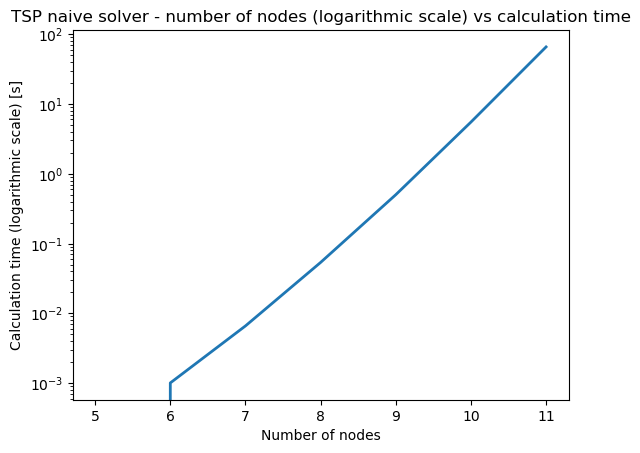

In [18]:
import matplotlib.pyplot as plt


def plot_naive_solver__calculation_time_vs_number_of_nodes(x, y, is_estimated=False):
    fig, ax = plt.subplots()

    ax.plot(x, [t/1e9 for t in y], label="Calculation time", linewidth=2.0)
    if is_estimated:
        ax.plot(x, [pow(10,n) for n in x], label="Exponential complexity", linewidth=0.5)
        plt.legend()
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Calculation time (logarithmic scale) [s]")

    plt.title(f"TSP naive solver - number of nodes (logarithmic scale) vs{' estimated' if is_estimated else ''} calculation time")
    plt.yscale("log")
    plt.show()

plot_naive_solver__calculation_time_vs_number_of_nodes(naive_solver_data[0], naive_solver_data[2])

In [19]:
def create_df__number_of_nodes_vs_calculation_time(x, y):
    return pd.DataFrame({'Number of nodes': x,'Estimated calculation time': [TSPUtils.parse_timedelta(t) for t in y]})
create_df__number_of_nodes_vs_calculation_time(naive_solver_data[0], naive_solver_data[2])

,Number of nodes,Estimated calculation time
0,5,0 ns
1,6,0.10042 ms
2,7,0.65903 ms
3,8,5.3575 ms
4,9,50.05089 ms
5,10,5.4979791 s
6,11,1.0957079216666668 m


#### Estimated calculation time

In [20]:
import statistics

def calculate_estimated_operation_time_ns():
    node_counts, calculation_times = naive_solver_data[0][2:], naive_solver_data[2][2:]
    operation_times = [calculation_times[i] / math.factorial(node_counts[i]) for i in range(len(node_counts))]
    print(operation_times)
    return statistics.mean(operation_times)

estimated_operation_time_ns = calculate_estimated_operation_time_ns()
print(f"estimated_operation_time_ns is {estimated_operation_time_ns}")

[1307.5992063492063, 1328.7450396825398, 1379.2683531746031, 1515.0956514550264, 1646.9876167428251]
estimated_operation_time_ns is 1435.5391734808402


In [21]:
naive_solver_calculation_time_data_estimated = [], []
for n in range(5, 100):
    naive_solver_calculation_time_data_estimated[0].append(n)
    naive_solver_calculation_time_data_estimated[1].append(TSPUtils.estimate_run_time_as_number(n, estimated_operation_time_ns=estimated_operation_time_ns))

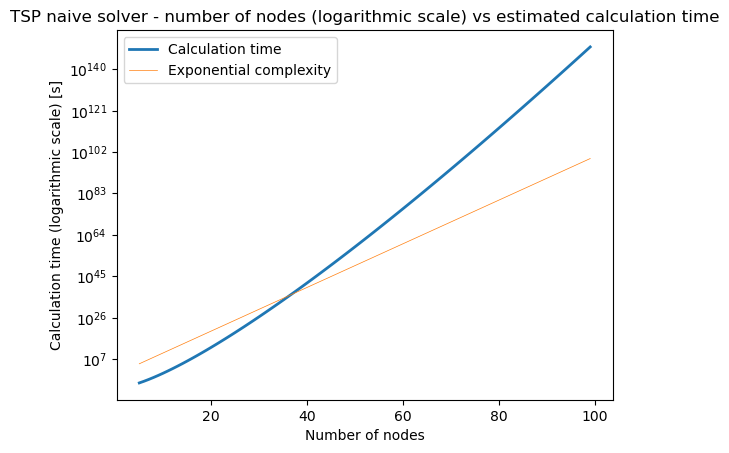

In [22]:
plot_naive_solver__calculation_time_vs_number_of_nodes(*naive_solver_calculation_time_data_estimated, is_estimated=True)

In [23]:
create_df__number_of_nodes_vs_calculation_time(*naive_solver_calculation_time_data_estimated)[:20]

,Number of nodes,Estimated calculation time
0,5,0.01722647008177008 ms
1,6,0.10335882049062049 ms
2,7,0.7235117434343434 ms
3,8,5.7880939474747475 ms
4,9,52.09284552727273 ms
5,10,5.209284552727273 s
6,11,57.30213008 s
7,12,11.460426016 m
8,13,2.4830923034666665 hr
9,14,1.4484705103555555 days


### Nearest neighbor solver

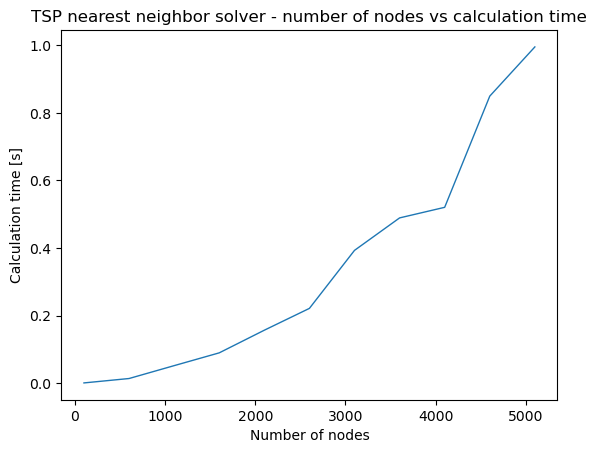

In [24]:
def plot_nn_solver__calculation_time_vs_number_of_nodes():
    x, y = [], []
    for number_of_nodes in range(100, 5500, 500):
        rates = TSPUtils.get_random_rates(number_of_nodes)
        solver = NearestNeighborSolver(rates)
        result = solver.solve_and_measure_time()
        x.append(number_of_nodes)
        y.append(result[2] / 1e9)

    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=1)
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Calculation time [s]")

    plt.title("TSP nearest neighbor solver - number of nodes vs calculation time")

    plt.show()

plot_nn_solver__calculation_time_vs_number_of_nodes()

### Genetic solver

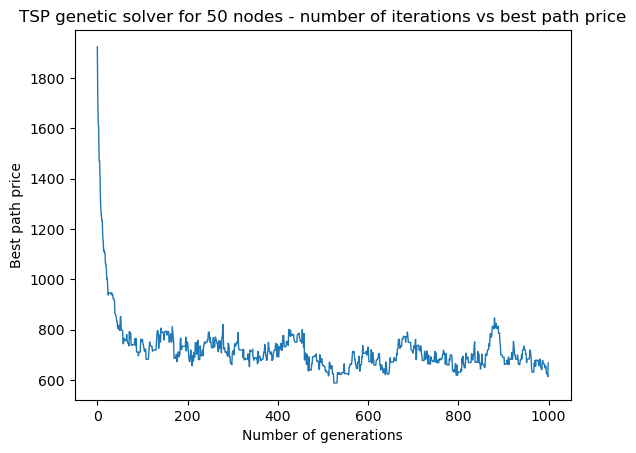

In [25]:
def plot_genetic_solver__score_vs_number_of_iterations():
    rates = TSPUtils.get_random_rates(50)
    solver = GeneticSolver(rates, population_size=40, tournament_size=20)
    result = solver.run(1000, collect_each_generation=True)
    x, y = [point for point in zip(*result)]
    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=1)
    ax.set_xlabel("Number of generations")
    ax.set_ylabel("Best path price")
    
    plt.title("TSP genetic solver for 50 nodes - number of iterations vs best path price")

    plt.show()

plot_genetic_solver__score_vs_number_of_iterations()

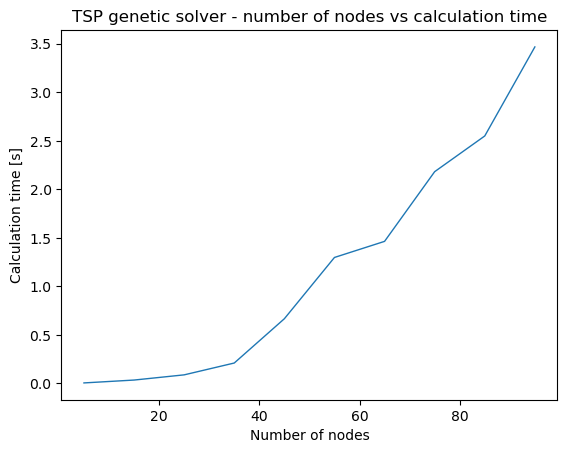

In [26]:
def plot_genetic_solver__calculation_time_vs_number_of_nodes():
    x, y = [], []
    for number_of_nodes in range(5, 100, 10):
        rates = TSPUtils.get_random_rates(number_of_nodes)
        solver = GeneticSolver(rates)
        result = solver.solve_and_measure_time()
        x.append(number_of_nodes)
        y.append(result[2] / 1e9)
    
    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=1)
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Calculation time [s]")

    plt.title("TSP genetic solver - number of nodes vs calculation time")

    plt.show()

plot_genetic_solver__calculation_time_vs_number_of_nodes()

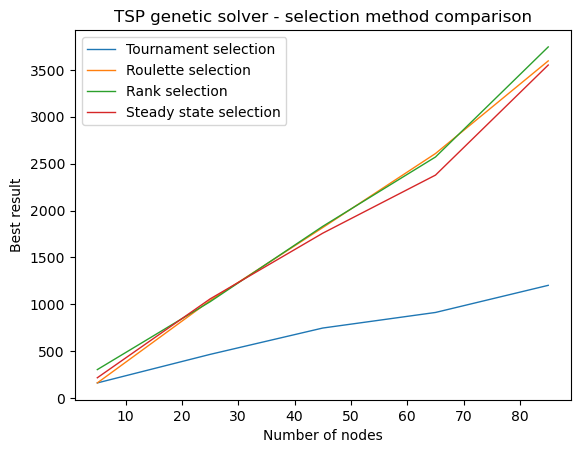

In [27]:
def plot_genetic_solver__selection_method():
    x, y_a, y_b, y_c, y_d = [], [], [], [], []
    for number_of_nodes in range(5, 100, 20):
        rates = TSPUtils.get_random_rates(number_of_nodes)
        solver_a = GeneticSolver(rates, selection_method="tournament")
        solver_b = GeneticSolver(rates, selection_method="roulette")
        solver_c = GeneticSolver(rates, selection_method="rank")
        solver_d = GeneticSolver(rates, selection_method="steady_state")
        x.append(number_of_nodes)
        y_a.append(solver_a.solve()[1])
        y_b.append(solver_b.solve()[1])
        y_c.append(solver_c.solve()[1])
        y_d.append(solver_d.solve()[1])

    fig, ax = plt.subplots()

    ax.plot(x, y_a, label="Tournament selection", linewidth=1)
    ax.plot(x, y_b, label="Roulette selection", linewidth=1)
    ax.plot(x, y_c, label="Rank selection", linewidth=1)
    ax.plot(x, y_d, label="Steady state selection", linewidth=1)
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Best result")

    plt.title("TSP genetic solver - selection method comparison")

    plt.legend()
    plt.show()


plot_genetic_solver__selection_method()

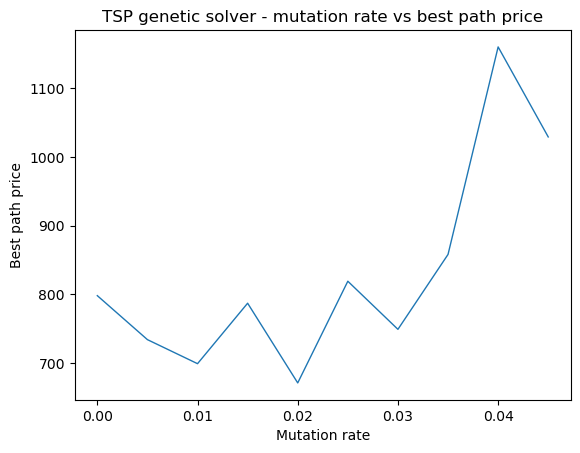

In [28]:
def plot_genetic_solver__score_vs_mutation_rate():
    rates = TSPUtils.get_random_rates(50)
    x,y = [],[]
    for mutation_rate in np.arange(0,0.05,.005):
        x.append(mutation_rate)
        y.append(GeneticSolver(rates, mutation_rate=mutation_rate).solve()[1])
    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=1)
    ax.set_xlabel("Mutation rate")
    ax.set_ylabel("Best path price")

    plt.title("TSP genetic solver - mutation rate vs best path price")

    plt.show()

plot_genetic_solver__score_vs_mutation_rate()

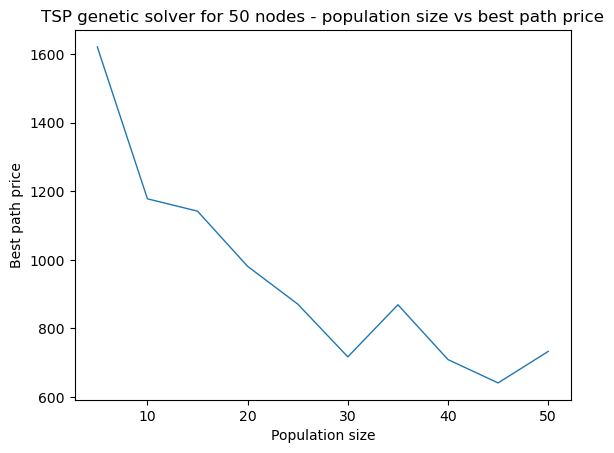

In [29]:
def plot_genetic_solver__score_vs_population_size():
    rates = TSPUtils.get_random_rates(50)
    x,y = [],[]
    for population_size in range(5, 55, 5):
        x.append(population_size)
        y.append(GeneticSolver(rates, population_size=population_size).solve()[1])
    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=1)
    ax.set_xlabel("Population size")
    ax.set_ylabel("Best path price")

    plt.title("TSP genetic solver for 50 nodes - population size vs best path price")

    plt.show()

plot_genetic_solver__score_vs_population_size()

### Algorithms comparison

In [30]:
def create_alg_comparison_df():
    y_nn, t_nn, y_ga, t_ga = [], [], [], []
    for rates in naive_solver_rates:
        result_nn = NearestNeighborSolver(rates).solve_and_measure_time()
        y_nn.append(result_nn[1])
        t_nn.append(result_nn[2])
        result_ga = NearestNeighborSolver(rates).solve_and_measure_time()
        y_ga.append(result_ga[1])
        t_ga.append(result_ga[2])
    return pd.DataFrame({'Num of nodes': naive_solver_data[0], 'Naive solver score': naive_solver_data[1], 'Nearest-n score': y_nn,
                        'Genetic alg score': y_ga, 'Naive solver time': [TSPUtils.parse_timedelta(t) for t in naive_solver_data[2]],
                         'Nearest-n time': [TSPUtils.parse_timedelta(t) for t in t_nn],
                         'Genetic alg time': [TSPUtils.parse_timedelta(t) for t in t_ga]
                         })
alg_comparison_df = create_alg_comparison_df()
alg_comparison_df

,Num of nodes,Naive solver score,Nearest-n score,Genetic alg score,Naive solver time,Nearest-n time,Genetic alg time
0,5,223,228,228,0 ns,0 ns,0 ns
1,6,187,202,200,0.10042 ms,0 ns,0 ns
2,7,204,333,333,0.65903 ms,0 ns,0 ns
3,8,153,227,195,5.3575 ms,0 ns,0 ns
4,9,94,94,108,50.05089 ms,0 ns,0 ns
5,10,165,223,191,5.4979791 s,0 ns,0 ns
6,11,179,211,179,1.0957079216666668 m,0 ns,0 ns


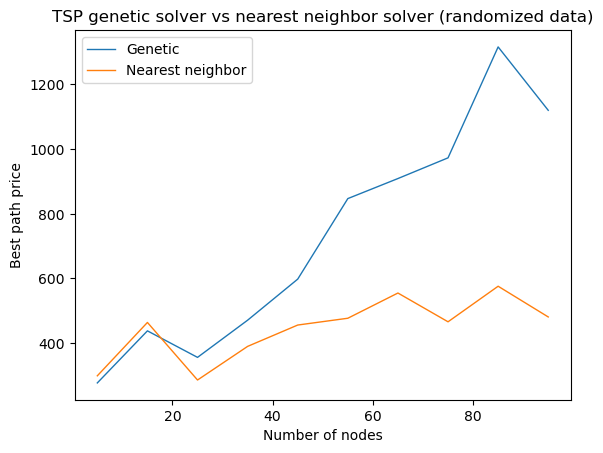

In [31]:
#!warning! execution of this cell takes up to 1 minute
def plot_genetic_solver_vs_nearest_neighbor_solver():
    x, y_a, y_b = [], [], []
    for num_of_rates in range(5, 100, 10):
        rates = TSPUtils.get_random_rates(num_of_rates)
        x.append(num_of_rates)
        y_a.append(GeneticSolver(rates).solve(number_of_generations=num_of_rates*5)[1])
        y_b.append(NearestNeighborSolver(rates).solve()[1])

    fig, ax = plt.subplots()

    ax.plot(x, y_a, linewidth=1, label="Genetic")
    ax.plot(x, y_b, linewidth=1, label="Nearest neighbor")
    ax.set_xlabel("Number of nodes")
    ax.set_ylabel("Best path price")
    ax.legend()

    plt.title("TSP genetic solver vs nearest neighbor solver (randomized data)")
    plt.show()
plot_genetic_solver_vs_nearest_neighbor_solver()

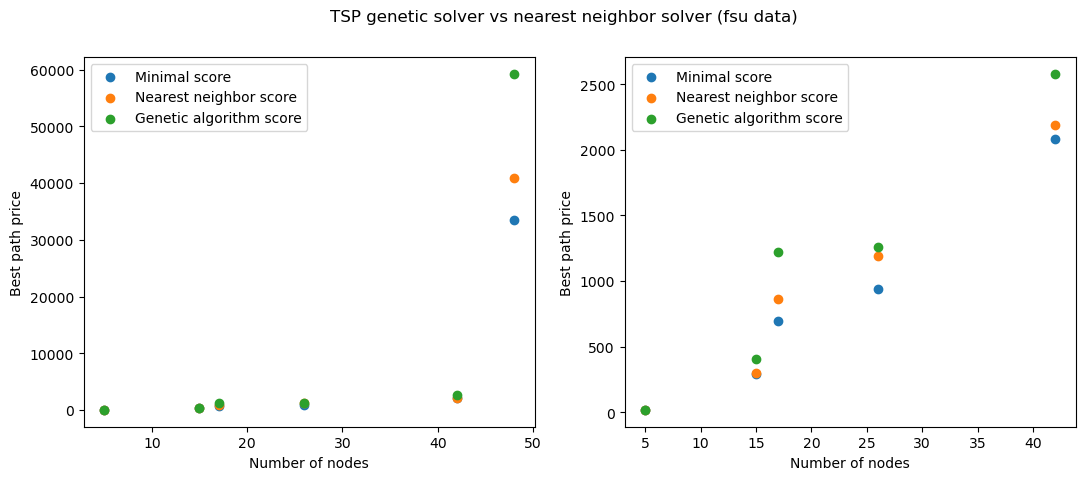

In [32]:
def plot_fsu_test_data_scores():
    x = sorted(fsu_test_result_df['Num of nodes'].to_numpy())
    y_min = sorted(fsu_test_result_df['Min score'].to_numpy())
    y_nn = sorted(fsu_test_result_df['Nearest-n score'].to_numpy())
    y_ga = sorted(fsu_test_result_df['Genetic score'].to_numpy())
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12.8, 4.8))
    
    for (ax, include_edge_case) in zip([ax1, ax2],[True, False]):
        _x = x if include_edge_case else x[:-1]
        _y_min = y_min if include_edge_case else y_min[:-1]
        _y_nn = y_nn if include_edge_case else y_nn[:-1]
        _y_ga = y_ga if include_edge_case else y_ga[:-1]
        ax.scatter(_x, _y_min, label="Minimal score")
        ax.scatter(_x, _y_nn, label="Nearest neighbor score")
        ax.scatter(_x, _y_ga, label="Genetic algorithm score")
        ax.set_xlabel("Number of nodes")
        ax.set_ylabel("Best path price")
        ax.legend()

    plt.suptitle("TSP genetic solver vs nearest neighbor solver (fsu data)")
    
    plt.show()
plot_fsu_test_data_scores()